In [1]:
# Import necessary libraries
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
from mpl_toolkits.mplot3d import Axes3D
import numpy as np

In [2]:
# Define a normalization function
def normalize(data):
    return (data - np.min(data)) / (np.max(data) - np.min(data))

In [3]:
# Function to parse date and calculate age
def parse_date(date):
    if pd.isnull(date):
        return pd.NaT
    for fmt in ['%Y-%m-%d', '%Y/%m/%d']:
        try:
            return pd.to_datetime(date, format=fmt)
        except ValueError:
            continue
    return pd.NaT

def calculate_age(birthdate):
    if pd.isna(birthdate):
        return np.nan
    today = datetime.today()
    return today.year - birthdate.year - ((today.month, today.day) < (birthdate.month, birthdate.day))

In [4]:
# Calculate save yards
def calculate_save_yards(row):
    # Calculate potential yards gained if not tackled
    potential_gain = row['prePenaltyPlayResult']
    
    # Adjust for penalties
    actual_gain = potential_gain - row['penaltyYards']
    
    # Calculate yards saved by the tackle
    yards_saved = actual_gain - row['playResult']
    
    return max(0, yards_saved)  # Ensure non-negative

def calculate_tackle_impact(row):
    if row['tackleType'] == 'Defense':
        save_yards = calculate_save_yards(row)
        return save_yards
    return 0

In [5]:
# Load datasets
def load_data(file_name, data_path='/kaggle/input/nfl-big-data-bowl-2024/'):
    return pd.read_csv(f'{data_path}{file_name}')

In [6]:
# Filter for positions relevant to tackling
# Here we define a list of player positions that are most involved in tackling.
# This includes defensive ends (DE), defensive tackles (DT), nose tackles (NT),
# outside linebackers (OLB), inside linebackers (ILB), middle linebackers (MLB),
# strong safeties (SS), free safeties (FS), and cornerbacks (CB).
# These positions are typically key players in defensive strategies, particularly in tackling.
relevant_positions = ['DE', 'DT', 'NT', 'OLB', 'ILB', 'MLB', 'SS', 'FS', 'CB']

In [7]:
# Loading the field image for visualizations
# This line reads an image file of the football field, which will be used 
# for plotting player positions and movements. The image is sourced from 
# the provided Kaggle competition data description.
# The image helps in visualizing the plays and player movements on a field layout.
field = plt.imread('/kaggle/input/field-image/field.png')

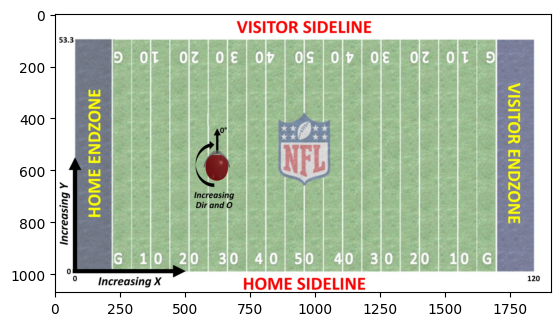

In [21]:
plt.imshow(field)

In [8]:
games_df = load_data('games.csv')
plays_df = load_data('plays.csv')
players_df = load_data('players.csv')
tackles_df = load_data('tackles.csv')

# Load and combine tracking data
tracking_files = [f'tracking_week_{week}.csv' for week in range(1, 10)]
tracking_data = pd.concat([load_data(file) for file in tracking_files])

In [9]:
# Selecting a specific game for detailed analysis
# Here, we choose a game by its ID for a focused study. 
# 'iloc[5]' selects the game ID at the 6th row in the 'games_df' DataFrame.
# You can change the index to select a different game.
specific_game_id = games_df['gameId'].iloc[5]

In [10]:
game_tackles_df = tackles_df[tackles_df['gameId'] == specific_game_id]

In [ ]:
# Identifying the player with the most tackles in the chosen game
# This line finds the player who made the most tackles in the specific game.
# 'value_counts()' counts the occurrences of each player ID, and 'idxmax()' 
# returns the ID of the player with the highest count (most tackles).
# But You can change any player id to analyse
chosen_player_id = game_tackles_df['nflId'].value_counts().idxmax()

In [11]:
# Merge datasets
complete_data = plays_df.merge(games_df, on='gameId')
complete_data = complete_data.merge(tackles_df, on=['gameId', 'playId'])
complete_data = complete_data.merge(tracking_data, on=['gameId', 'playId', 'nflId'])
complete_data = complete_data.merge(players_df[['nflId', 'position', 'birthDate', 'height', 'weight']], on='nflId')


In [12]:
complete_data['birthDate'] = complete_data['birthDate'].apply(parse_date)
complete_data['age'] = complete_data['birthDate'].apply(calculate_age)

# Convert height to numeric if necessary
if complete_data['height'].dtype == 'O':  # Checks if the height column is of object type (string)
    complete_data['height'] = complete_data['height'].apply(lambda x: int(x.split('-')[0]) * 12 + int(x.split('-')[1]) if '-' in x else int(x))

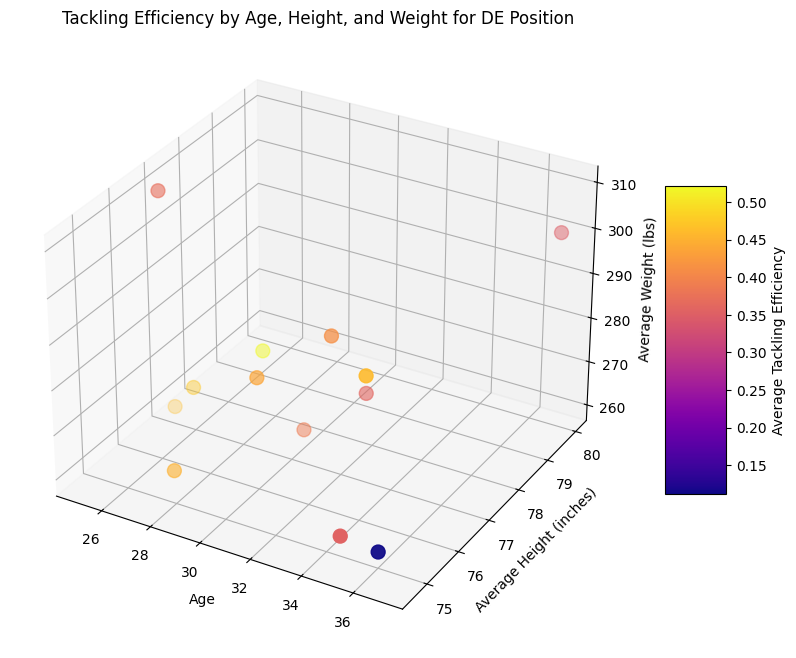

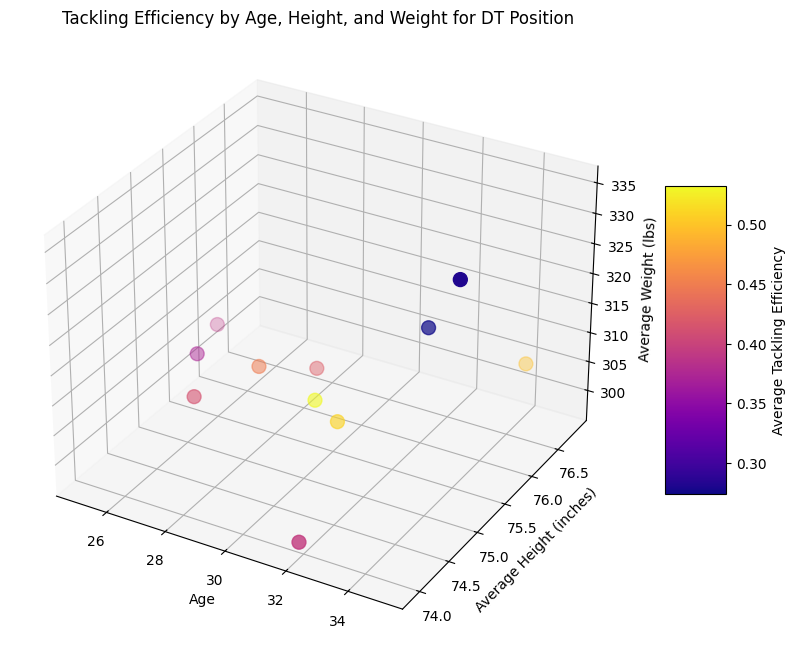

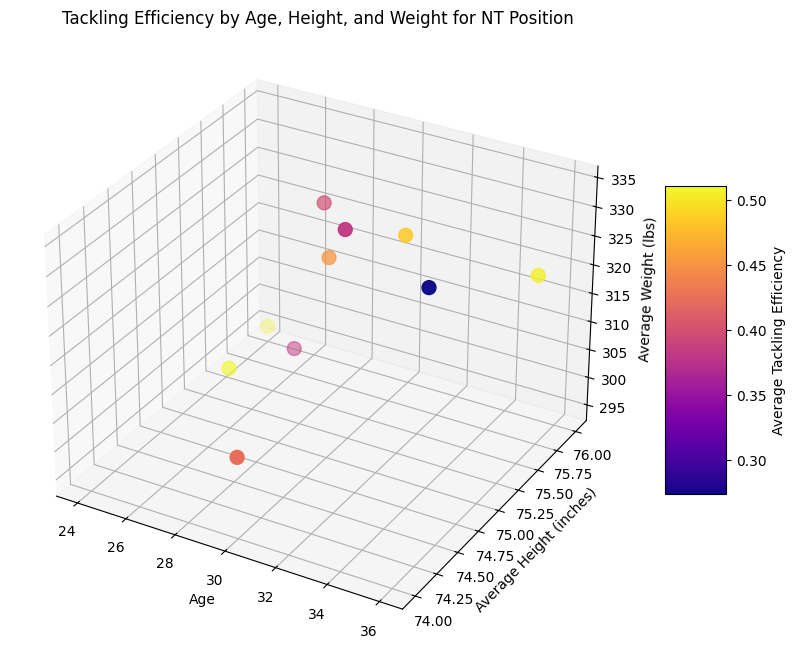

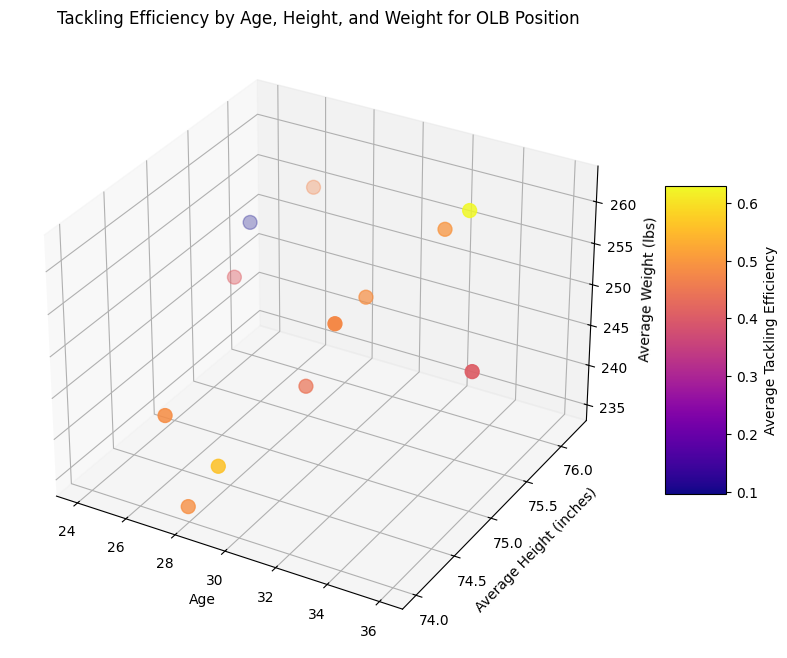

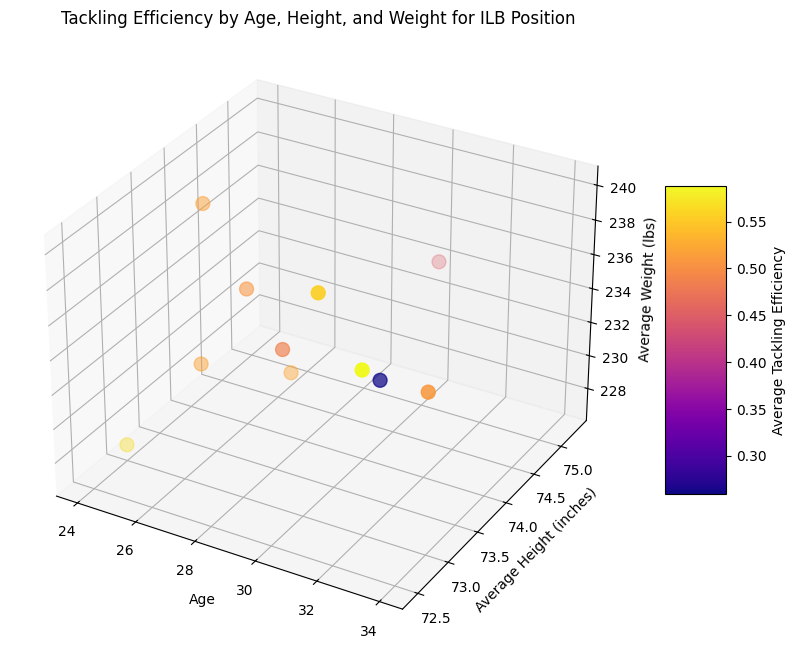

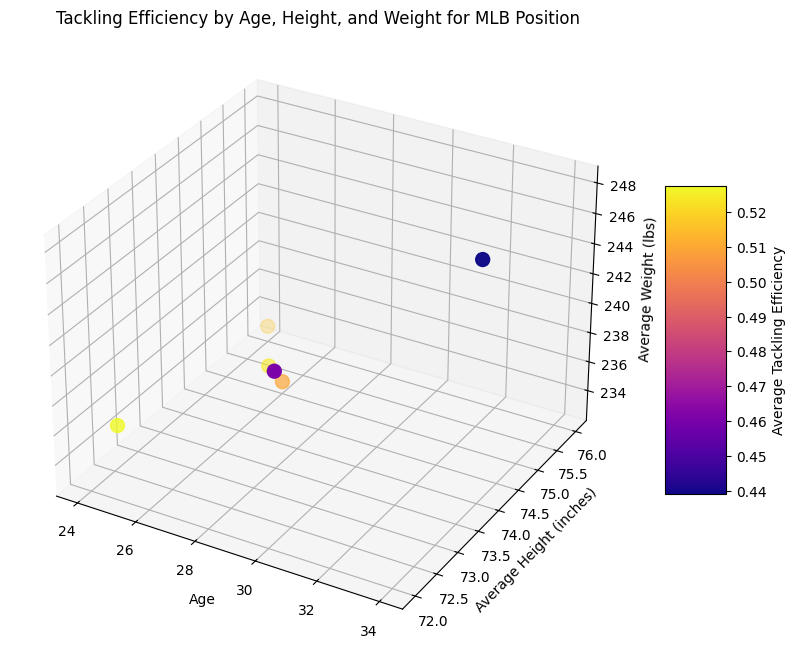

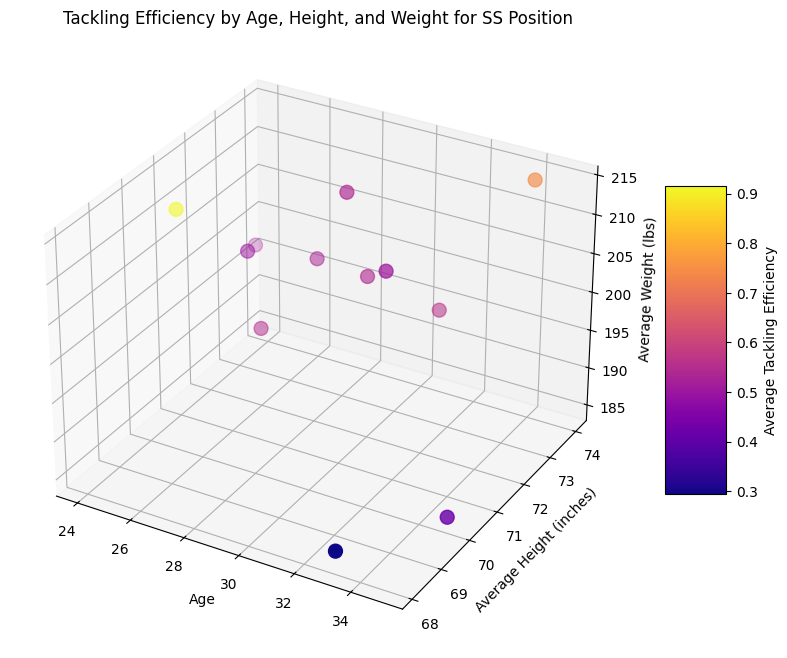

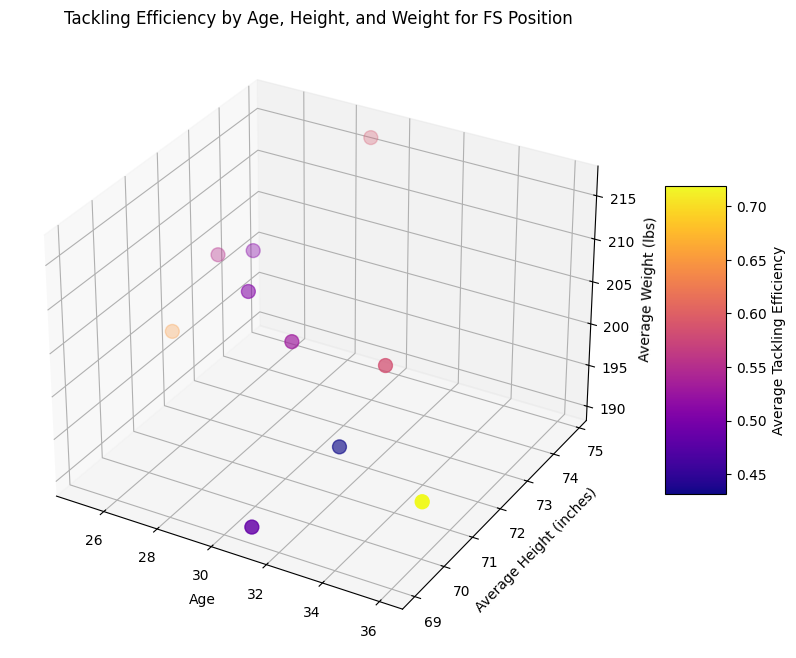

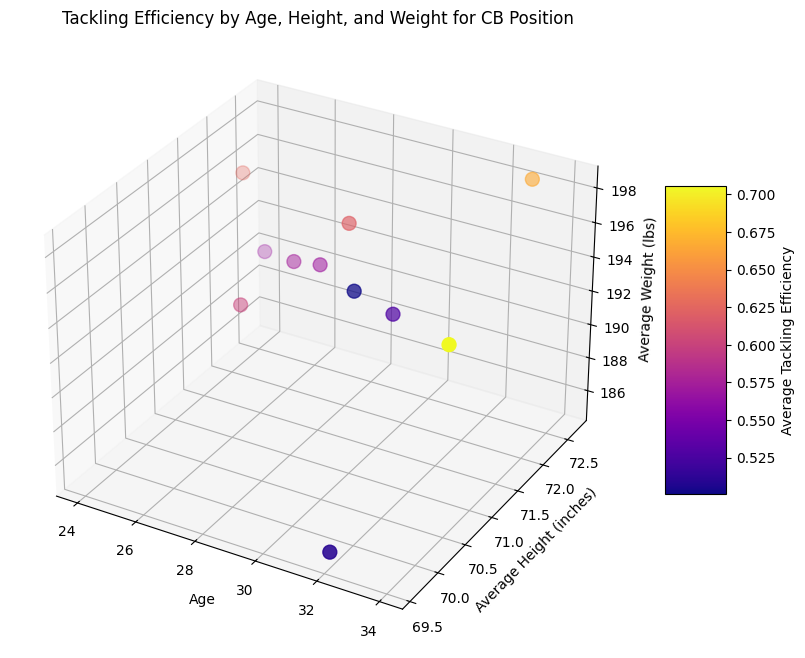

In [13]:
# Tackling Efficiency Analysis

for position in relevant_positions:
    position_data = complete_data[complete_data['position'] == position]
    age_stats = position_data.groupby('age').agg({'tackle': 'mean', 'height': 'mean', 'weight': 'mean'}).reset_index()
    fig = plt.figure(figsize=(10, 8))
    ax = fig.add_subplot(111, projection='3d')
    scatter = ax.scatter(age_stats['age'], age_stats['height'], age_stats['weight'], c=age_stats['tackle'], cmap='plasma', s=100)
    ax.set_xlabel('Age')
    ax.set_ylabel('Average Height (inches)')
    ax.set_zlabel('Average Weight (lbs)')
    ax.set_title(f'Tackling Efficiency by Age, Height, and Weight for {position} Position')
    fig.colorbar(scatter, ax=ax, shrink=0.5, aspect=5).set_label('Average Tackling Efficiency')
    plt.show()

In [14]:
# Choose a specific game for analysis
game_tracking_df = tracking_data[tracking_data['gameId'] == specific_game_id]

most_tackles_player_name = players_df[players_df['nflId'] == chosen_player_id]['displayName'].iloc[0]

In [15]:
# Filter tracking data for the most tackled player in the specific game
player_tracking_df = game_tracking_df[game_tracking_df['nflId'] == chosen_player_id]
player_tracking_with_play_df = player_tracking_df.merge(plays_df[['gameId', 'playId', 'playResult']], on=['gameId', 'playId'])
player_tracking_with_play_df['tackle_success'] = player_tracking_with_play_df['playResult'] <= 0
player_tracking_with_play_df['normalized_speed'] = normalize(player_tracking_with_play_df['s'])
player_tracking_with_play_df['normalized_acceleration'] = normalize(player_tracking_with_play_df['a'])

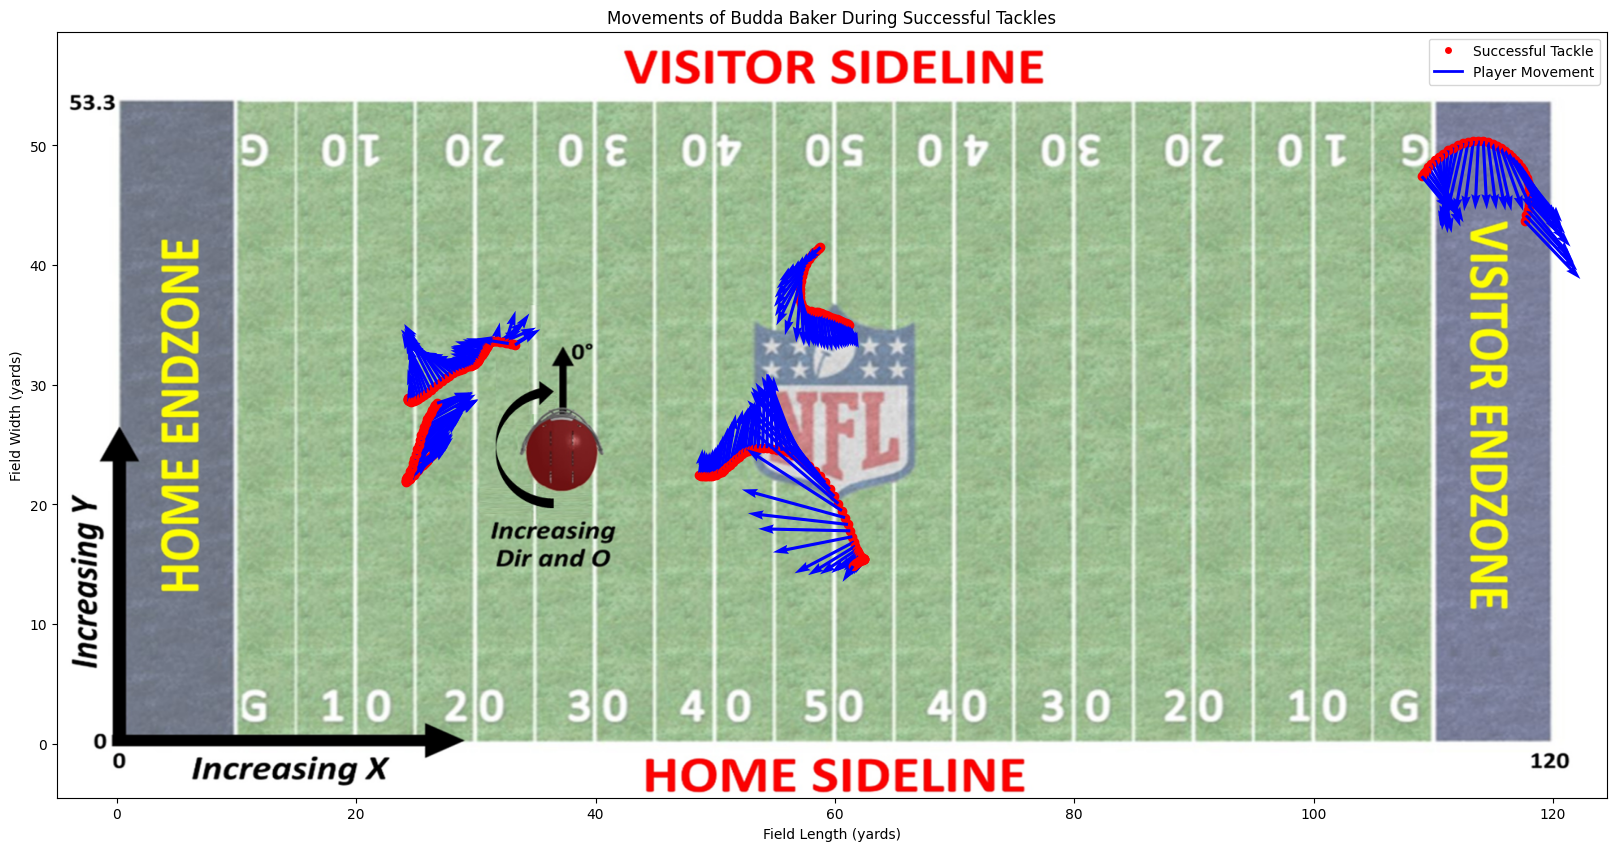

In [16]:
# First Figure: Player Movements During Successful Tackles
plt.figure(figsize=(20, 10))
plt.imshow(field, extent=[-5, 124.5, -4.5, 59.5])

successful_tackles = player_tracking_with_play_df[player_tracking_with_play_df['tackle_success']]
for index, row in successful_tackles.iterrows():
    plt.scatter(row['x'], row['y'], c='red')
    vector_scale = row['normalized_speed'] * 0.5
    plt.quiver(row['x'], row['y'], np.cos(np.radians(row['o']))*vector_scale,
               np.sin(np.radians(row['o']))*vector_scale, scale=5, color='blue', width=0.002)

# Manually create legend
red_dot = plt.Line2D(range(1), range(1), color="white", marker='o', markerfacecolor="red", label='Successful Tackle')
blue_line = plt.Line2D(range(1), range(1), color="blue", lw=2, label='Player Movement')
plt.legend(handles=[red_dot, blue_line])

plt.title(f'Movements of {most_tackles_player_name} During Successful Tackles')
plt.xlabel('Field Length (yards)')
plt.ylabel('Field Width (yards)')
plt.show()

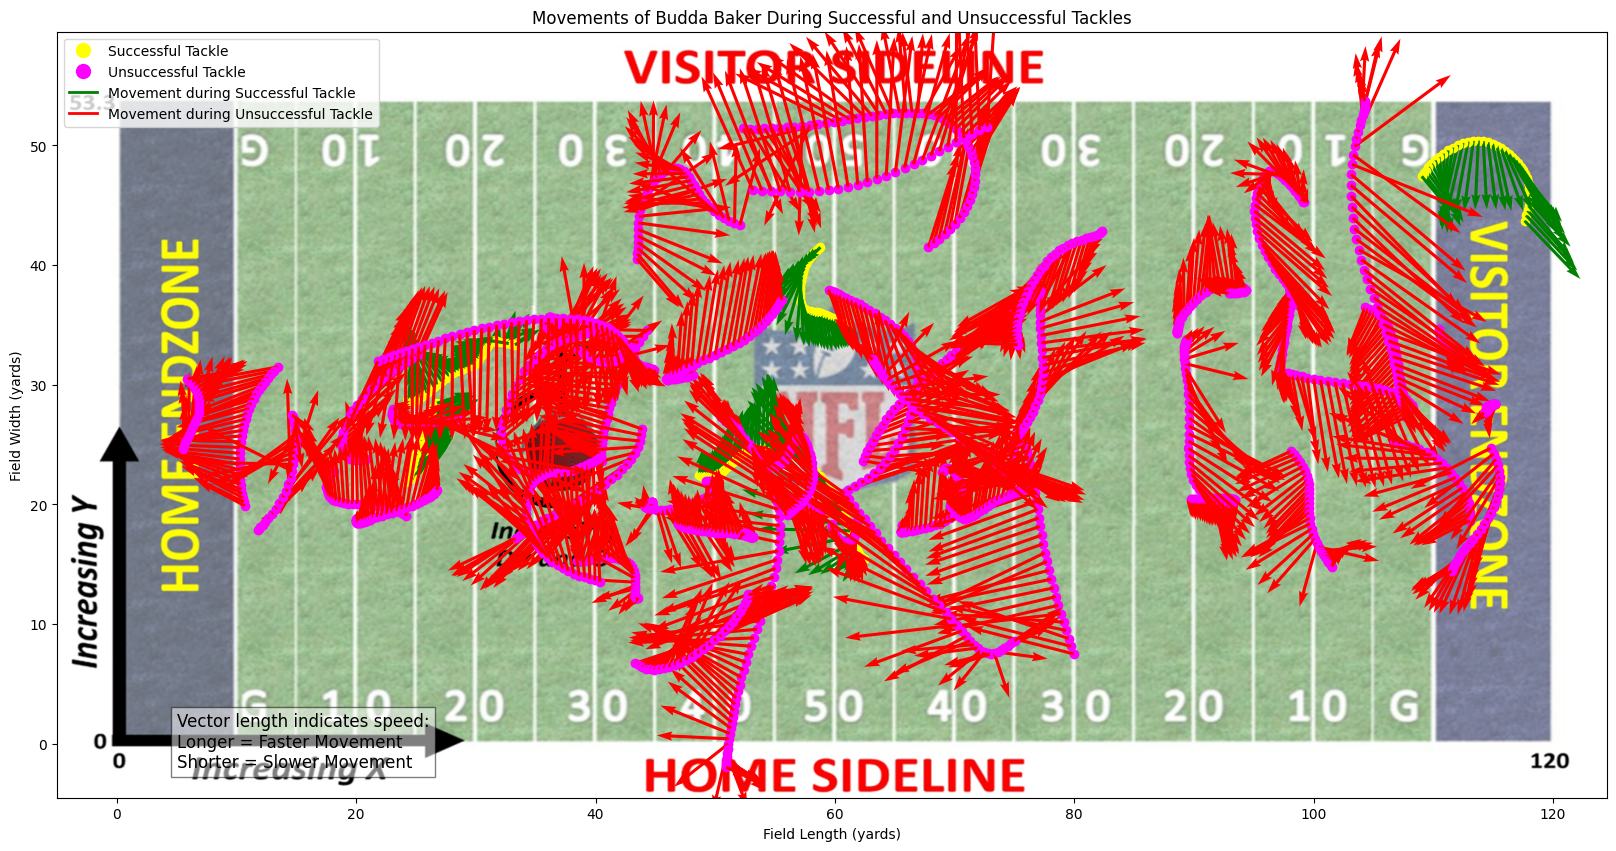

In [17]:
# Separate successful and unsuccessful tackles
successful_tackles = player_tracking_with_play_df[player_tracking_with_play_df['tackle_success'] == 1]
unsuccessful_tackles = player_tracking_with_play_df[player_tracking_with_play_df['tackle_success'] == 0]

# Separate successful and unsuccessful tackles
successful_tackles = player_tracking_with_play_df[player_tracking_with_play_df['tackle_success'] == 1]
unsuccessful_tackles = player_tracking_with_play_df[player_tracking_with_play_df['tackle_success'] == 0]

# Create figure for player movements
plt.figure(figsize=(20, 10))
plt.imshow(field, extent=[-5, 124.5, -4.5, 59.5])

# Plot successful tackles with movement
for index, row in successful_tackles.iterrows():
    plt.scatter(row['x'], row['y'], c='yellow', label='Successful Tackle' if index == 0 else "")
    vector_scale = row['normalized_speed'] * 0.5
    plt.quiver(row['x'], row['y'], np.cos(np.radians(row['o']))*vector_scale,
               np.sin(np.radians(row['o']))*vector_scale, scale=5, color='green', width=0.002)

# Plot unsuccessful tackles with movement
for index, row in unsuccessful_tackles.iterrows():
    plt.scatter(row['x'], row['y'], c='magenta', label='Unsuccessful Tackle' if index == 0 else "")
    vector_scale = row['normalized_speed'] * 0.5
    plt.quiver(row['x'], row['y'], np.cos(np.radians(row['o']))*vector_scale,
               np.sin(np.radians(row['o']))*vector_scale, scale=5, color='red', width=0.002)

# Manually create legend
legend_elements = [plt.Line2D([0], [0], color='yellow', marker='o', linestyle='None',
                              markersize=10, label='Successful Tackle'),
                   plt.Line2D([0], [0], color='magenta', marker='o', linestyle='None',
                              markersize=10, label='Unsuccessful Tackle'),
                   plt.Line2D([0], [0], color='green', lw=2, label='Movement during Successful Tackle'),
                   plt.Line2D([0], [0], color='red', lw=2, label='Movement during Unsuccessful Tackle')]
plt.legend(handles=legend_elements)

# Add movement length explanation
plt.text(5, -2, 'Vector length indicates speed:\nLonger = Faster Movement\nShorter = Slower Movement', fontsize=12, bbox=dict(facecolor='white', alpha=0.5))

# Set plot title and labels
plt.title(f'Movements of {most_tackles_player_name} During Successful and Unsuccessful Tackles')
plt.xlabel('Field Length (yards)')
plt.ylabel('Field Width (yards)')

# Show the plot
plt.show()

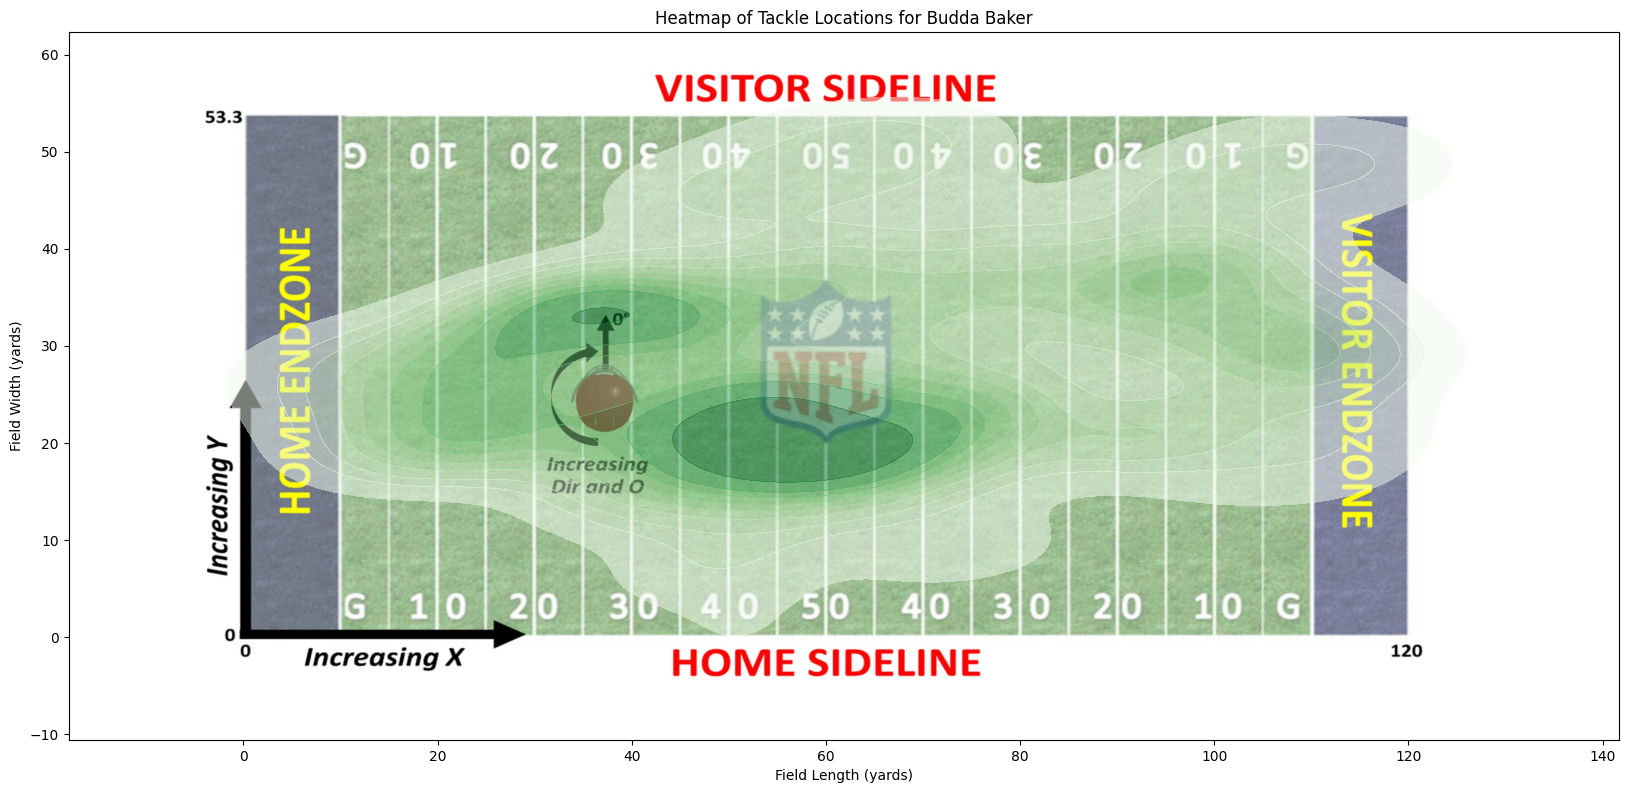

In [18]:
# Second Figure: Heatmap of Tackle Locations
plt.figure(figsize=(20, 10))
plt.imshow(field, extent=[-5, 124.5, -4.5, 59.5])

sns.kdeplot(
    data=player_tracking_with_play_df,
    x='x', y='y',
    cmap="Greens",
    fill=True,
    alpha=0.5
)

plt.title(f'Heatmap of Tackle Locations for {most_tackles_player_name}')
plt.xlabel('Field Length (yards)')
plt.ylabel('Field Width (yards)')
plt.show()

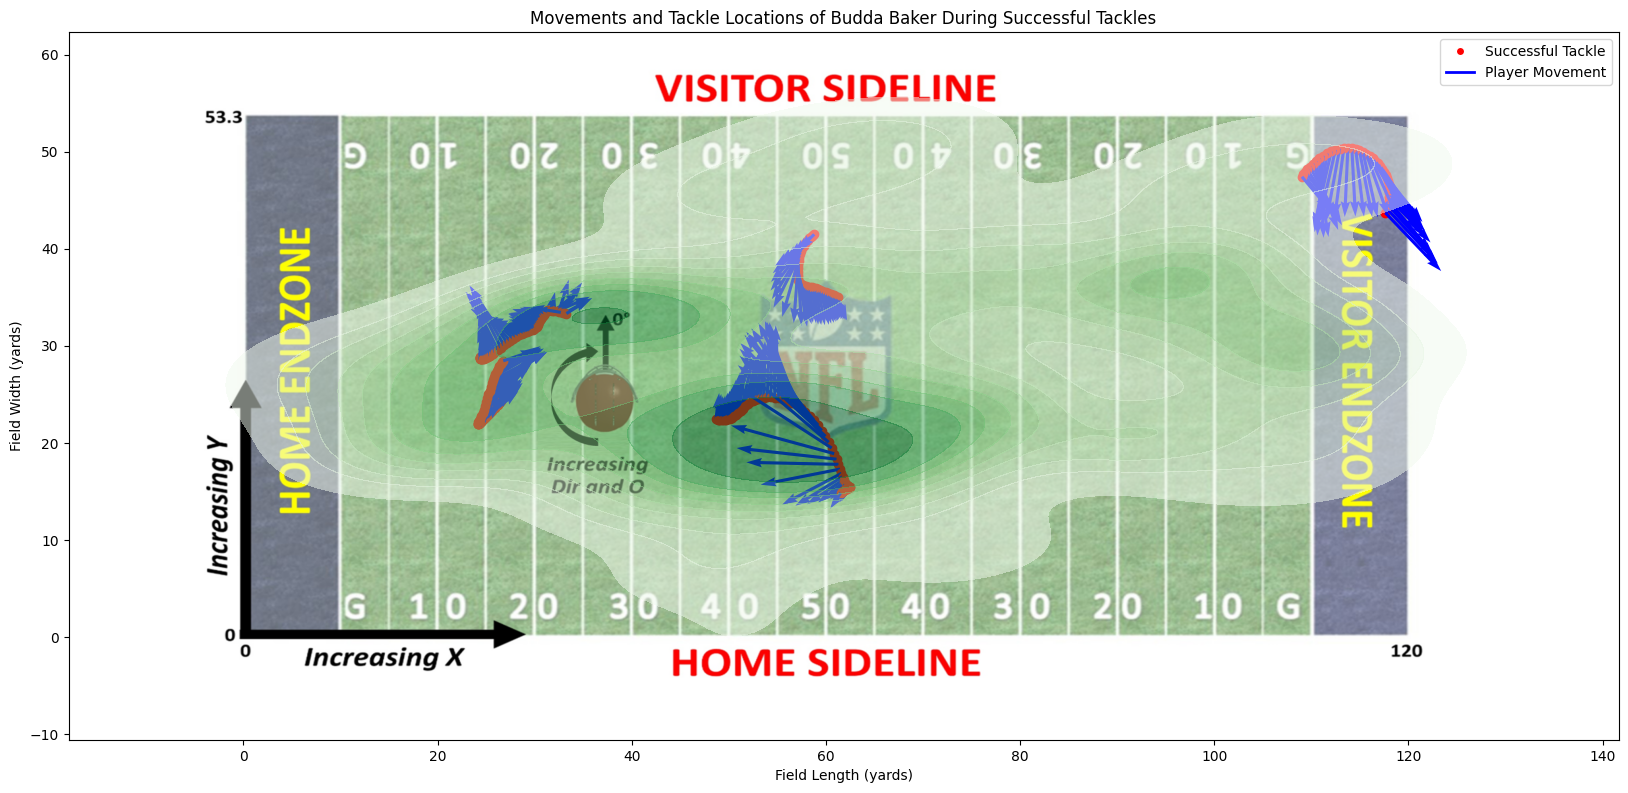

In [19]:
# Visualize the player's positions during successful tackles
plt.figure(figsize=(20, 10))
plt.imshow(field, extent=[-5, 124.5, -4.5, 59.5])

successful_tackles = player_tracking_with_play_df[player_tracking_with_play_df['tackle_success']]
for index, row in successful_tackles.iterrows():
    plt.scatter(row['x'], row['y'], c='red')
    vector_scale = row['normalized_speed'] * 0.5
    plt.quiver(row['x'], row['y'], np.cos(np.radians(row['o']))*vector_scale,
               np.sin(np.radians(row['o']))*vector_scale, scale=5, color='blue', width=0.002)

# Overlay the heatmap of tackle locations for the most tackled player
sns.kdeplot(
    data=player_tracking_with_play_df,
    x='x', y='y',
    cmap="Greens",
    fill=True,
    alpha=0.5
)

# Manually create legend
red_dot = plt.Line2D(range(1), range(1), color="white", marker='o', markerfacecolor="red", label='Successful Tackle')
blue_line = plt.Line2D(range(1), range(1), color="blue", lw=2, label='Player Movement')
plt.legend(handles=[red_dot, blue_line])

plt.title(f'Movements and Tackle Locations of {most_tackles_player_name} During Successful Tackles')
plt.xlabel('Field Length (yards)')
plt.ylabel('Field Width (yards)')
plt.show()

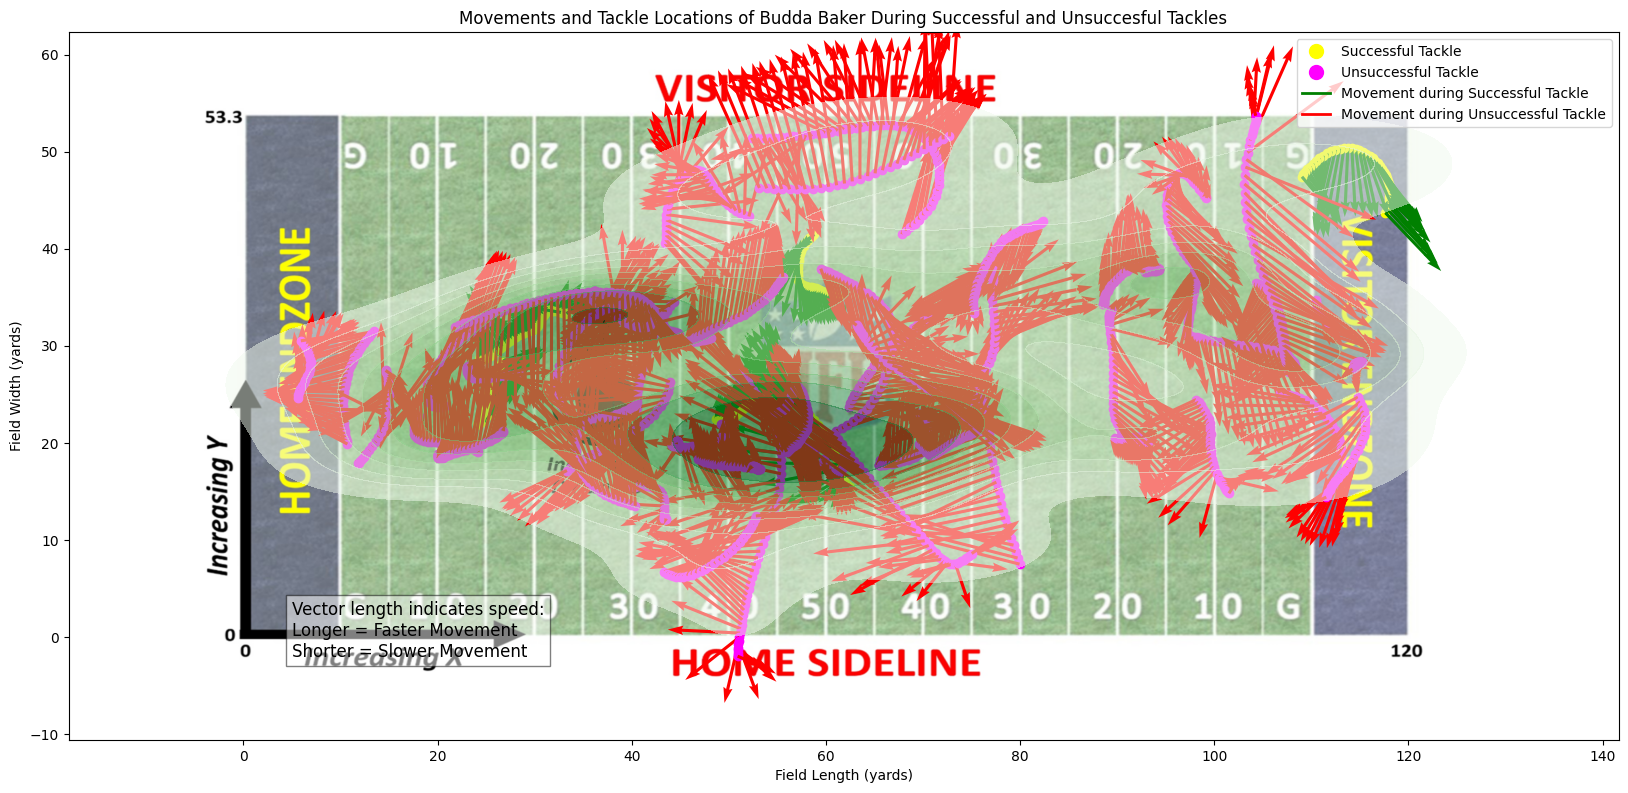

In [20]:
# Visualize the player's positions during successful tackles
plt.figure(figsize=(20, 10))
plt.imshow(field, extent=[-5, 124.5, -4.5, 59.5])

# Separate successful and unsuccessful tackles
successful_tackles = player_tracking_with_play_df[player_tracking_with_play_df['tackle_success'] == 1]
unsuccessful_tackles = player_tracking_with_play_df[player_tracking_with_play_df['tackle_success'] == 0]

# Plot successful tackles with movement
for index, row in successful_tackles.iterrows():
    plt.scatter(row['x'], row['y'], c='yellow', label='Successful Tackle' if index == 0 else "")
    vector_scale = row['normalized_speed'] * 0.5
    plt.quiver(row['x'], row['y'], np.cos(np.radians(row['o']))*vector_scale,
               np.sin(np.radians(row['o']))*vector_scale, scale=5, color='green', width=0.002)

# Plot unsuccessful tackles with movement
for index, row in unsuccessful_tackles.iterrows():
    plt.scatter(row['x'], row['y'], c='magenta', label='Unsuccessful Tackle' if index == 0 else "")
    vector_scale = row['normalized_speed'] * 0.5
    plt.quiver(row['x'], row['y'], np.cos(np.radians(row['o']))*vector_scale,
               np.sin(np.radians(row['o']))*vector_scale, scale=5, color='red', width=0.002)
    
# Overlay the heatmap of tackle locations for the most tackled player
sns.kdeplot(
    data=player_tracking_with_play_df,
    x='x', y='y',
    cmap="Greens",
    fill=True,
    alpha=0.5
)

# Manually create legend
legend_elements = [plt.Line2D([0], [0], color='yellow', marker='o', linestyle='None',
                              markersize=10, label='Successful Tackle'),
                   plt.Line2D([0], [0], color='magenta', marker='o', linestyle='None',
                              markersize=10, label='Unsuccessful Tackle'),
                   plt.Line2D([0], [0], color='green', lw=2, label='Movement during Successful Tackle'),
                   plt.Line2D([0], [0], color='red', lw=2, label='Movement during Unsuccessful Tackle')]
plt.legend(handles=legend_elements)


# Add movement length explanation
plt.text(5, -2, 'Vector length indicates speed:\nLonger = Faster Movement\nShorter = Slower Movement', fontsize=12, bbox=dict(facecolor='white', alpha=0.5))

plt.title(f'Movements and Tackle Locations of {most_tackles_player_name} During Successful and Unsuccesful Tackles')
plt.xlabel('Field Length (yards)')
plt.ylabel('Field Width (yards)')
plt.show()